# **"SnapBack" Alpha**

**“The price snaps back after a sharp rise or fall.”**

## **Step1. Summary of Key Paper**

### **1) Paper Information**

**Title:** Does the Stock Market Overreact?

**Authors:** Werner F. M. De Bondt, Richard Thaler

**Journal:** The Journal of Finance

**Volume:** Vol. 40, No. 3

**Publication Date:** July 1985

**Pages:** 793–805

**DOI:** 10.1111/j.1540-6261.1985.tb05004.x

### **2) Research Background & Question**

Psychological studies suggest that people tend to overreact to dramatic news.

→ Do such behavioral biases also influence financial market prices?

### **Hypothesis 1: Mean Reversion in Extreme Winners/Losers**

“Stocks that were extreme winners or losers tend to reverse in performance later.”

**Confirmed Findings**

After 36 months:

Loser portfolio: +19.6% excess return (vs. market)

Winner portfolio: −5.0%

Difference (Loser − Winner): +24.6% (t = 2.20)

**Seasonality (January Effect)**

Excess returns in January are especially pronounced:

Month 1: +8.1% (t = 3.21)

Month 13: +5.6% (t = 3.07)

Month 25: +4.0% (t = 2.76)

**Persistence**

The reversal pattern continues even in 5-year tests.

The strong January rebound for losers appears consistently over time.

### **Hypothesis 2: Greater Extremes → Stronger Reversals**

“The more extreme the past return, the stronger the future reversal.”

**Confirmed Findings**

Authors show that longer formation periods and more extreme stock selection increase the strength of reversal (and t-values).

No reversal observed when formation period is short.

| Formation Period               | Horizon | Return Difference | t-Value | Notes           |
| ------------------------------ | ------- | ----------------- | ------- | --------------- |
| 3 years                        | 36 mo   | **+24.6%**        | 2.20    | Strong reversal |
| 5 years                        | 60 mo   | **+31.9%**        | 3.28    | Even stronger   |
| 2 years                        | 18 mo   | **+13.6%**        | 2.02    | Smaller effect  |
| 2 years                        | 24 mo   | **+10.1%**        | 1.41    | Weaker          |
| 2 yrs (top/bottom 35 stocks)   | 18 mo   | **+13.6%**        | —       | Stronger        |
| 2 yrs (decile, avg. 82 stocks) | 18 mo   | **+10.5%**        | —       | Weaker          |

### **3) Key Implications**

Investors overweight recent information due to representativeness heuristic → leads to price overreaction → followed by long-term reversal

## **Step 2. Hypothesis Setup**

**"Stocks with extremely negative EPS surprises may reflect excessive pessimism, leading to potential future rebounds."**\
(Analogous to "loser stocks" in the original paper.)

**"Stocks with extremely positive EPS surprises may reflect excessive optimism, leading to potential future reversals."**\
(Analogous to "winner stocks" in the original paper.)

**"The larger the absolute value of the EPS surprise, the stronger the subsequent reversal is expected to be."**

## **Step 3. Data Loading**

### **Comparison: KOSPI vs. KOSPI 200**

| **Category**                      | **KOSPI (All Stocks)**                                                                                                                                                                  | **KOSPI 200**                                                                                                                                                                                                            |
| --------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| **Data Quality & Reliability**    | Higher exposure to small/mid-cap stocks → prone to low liquidity, sharp volatility, and data distortions (e.g., speculative trading, short-term events). Factor signals are more noisy. | Large-cap and highly liquid companies → price and financial data are more reliable. Factor performance tends to be more stable and reproducible.                                                                         |
| **Trading Costs & Executability** | Many illiquid names cause higher slippage and transaction costs during portfolio rebalancing. Backtest-to-live performance gap can be significant.                                      | High liquidity and narrow bid-ask spreads → efficient execution even for large-scale portfolios. Reduces slippage and ensures strategy scalability.                                                                      |
| **Alpha Opportunities**           | Greater chance to find hidden opportunities due to information asymmetry. However, higher volatility and greater risk management burden.                                                | Harder to extract alpha as large caps are more information-efficient. Still, systematic factor strategies (value, momentum, quality, low-vol) can generate persistent alpha.                                             |
| **Benchmarking & Communication**  | Less widely used as a benchmark, making excess return explanations less intuitive for investors.                                                                                        | Widely recognized as the representative benchmark for the Korean market. Also serves as the underlying index for derivatives (futures, options). Clear advantage for performance attribution and investor communication. |

### **Why Is It Harder to Find Alpha in Highly Liquid Stocks?**

**1) Higher Information Efficiency**\
Highly liquid stocks are constantly analyzed and traded by institutions, foreign investors, and quantitative funds.\
As a result, new information is incorporated into prices quickly, leaving little room for mispricing or prolonged undervaluation.\
In other words, it becomes much harder to find “hidden opportunities.”

**2) Faster Arbitrage Correction**\
In large-cap stocks, even small pricing discrepancies are quickly exploited and eliminated by arbitrageurs.\
By contrast, in less liquid small- and mid-cap stocks, fewer market participants are involved, so similar mispricings can persist longer providing more alpha opportunities.

In [103]:
import pandas as pd
import numpy as np
from datetime import datetime

file_path = "kospi200.xlsx"

# EPS
eps_raw = pd.read_excel(file_path, sheet_name="eps")

# 메타데이터 행 제거
def looks_like_symbol(x):
    try:
        return isinstance(x, str) and len(x) >= 2 and x[0] in ("A","K") and x[1:].isdigit()
    except:
        return False

start_idx = eps_raw.index[eps_raw.iloc[:,0].apply(looks_like_symbol)][0]
eps = eps_raw.iloc[start_idx:].copy()
eps.columns = ["Symbol","Name","결산월","회계년","주기","EPS_adj","EPS_reported"]

for col in ["EPS_adj","EPS_reported","결산월","회계년"]:
    eps[col] = (
        eps[col]
        .astype(str)
        .str.replace(",","", regex=False)
        .str.strip()
        .replace({"": np.nan, "nan": np.nan})
    )
eps[["결산월","회계년"]] = eps[["결산월","회계년"]].astype(float).astype("Int64")
for col in ["EPS_adj","EPS_reported"]:
    eps[col] = pd.to_numeric(eps[col], errors="coerce")

def quarter_end_date(fy, period, closing_month=12):
    if pd.isna(fy) or pd.isna(period):
        return pd.NaT
    fy = int(fy)
    period = str(period).upper()
    month_map = {"1Q":3, "2Q":6, "3Q":9, "4Q":12, "ANNUAL": closing_month, "연간": closing_month, "Annual":"ANNUAL"}
    m = month_map.get(period, None)
    if m is None:
        return pd.NaT
    last_day = pd.Period(f"{fy}-{m:02d}", freq="M").end_time.date()
    return pd.to_datetime(last_day)

eps["period_end"] = eps.apply(lambda r: quarter_end_date(r["회계년"], r["주기"], closing_month=12), axis=1)
eps_long = eps[["Symbol","Name","회계년","주기","period_end","EPS_adj","EPS_reported"]].dropna(subset=["period_end"]).reset_index(drop=True)

eps_long.head()

,Symbol,Name,회계년,주기,period_end,EPS_adj,EPS_reported
0,A005930,삼성전자,2014,1Q,2014-03-31,815.08,879.86
1,A005930,삼성전자,2014,2Q,2014-06-30,802.35,726.08
2,A005930,삼성전자,2014,3Q,2014-09-30,503.48,486.14
3,A005930,삼성전자,2014,4Q,2014-12-31,467.71,621.38
4,A005930,삼성전자,2014,Annual,2014-12-31,2563.21,2713.47


In [104]:
# EPS Coverage
total_rows = len(eps_long)

coverage = eps_long[["EPS_adj", "EPS_reported"]].notna().sum() / total_rows

print(coverage)

EPS_adj         0.758455
EPS_reported    0.911091
dtype: float64


In [105]:
eps_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Symbol        11000 non-null  object        
 1   Name          11000 non-null  object        
 2   회계년           11000 non-null  Int64         
 3   주기            11000 non-null  object        
 4   period_end    11000 non-null  datetime64[ns]
 5   EPS_adj       8343 non-null   float64       
 6   EPS_reported  10022 non-null  float64       
dtypes: Int64(1), datetime64[ns](1), float64(2), object(3)
memory usage: 612.4+ KB


In [106]:
# Adj Close
px_raw = pd.read_excel(file_path, sheet_name="adj close", header=None)

date_row_mask = px_raw.iloc[:,0].astype(str).str.match(r"\d{4}-\d{2}-\d{2}")
first_date_idx = date_row_mask[date_row_mask].index.min()

symbol_row_idx = px_raw.index[px_raw.astype(str).apply(lambda r: r.str.contains("Symbol").any(), axis=1)].min()
symbols = px_raw.iloc[symbol_row_idx+1].tolist()
symbols[0] = "Date"

px = px_raw.iloc[first_date_idx:].copy()
px.columns = symbols
px = px.loc[:, ~px.columns.isna()]

for c in px.columns[1:]:
    px[c] = (
        px[c]
        .astype(str)
        .str.replace(",","", regex=False)
        .str.strip()
        .replace({"": np.nan, "nan": np.nan})
    )
    px[c] = pd.to_numeric(px[c], errors="coerce")

price_long = (
    px.melt(id_vars=["Date"], var_name="Symbol", value_name="AdjClose")
      .assign(Date=lambda d: pd.to_datetime(d["Date"]))
      .reset_index(drop=True)
)

price_long.head()

,Date,Symbol,AdjClose
0,2014-03-31,삼성전자,26860.0
1,2014-06-30,삼성전자,26440.0
2,2014-09-30,삼성전자,23680.0
3,2014-12-31,삼성전자,26540.0
4,2015-03-31,삼성전자,28820.0


In [107]:
# Adj Close Coverage
total_rows = len(price_long)
coverage_adjclose = price_long["AdjClose"].notna().sum() / total_rows

print("AdjClose Coverage:", coverage_adjclose)

AdjClose Coverage: 0.8995744680851064


In [108]:
price_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9400 entries, 0 to 9399
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      9400 non-null   datetime64[ns]
 1   Symbol    9400 non-null   object        
 2   AdjClose  8456 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 220.4+ KB


In [109]:
import pandas as pd
import numpy as np

eps_q = eps_long[eps_long["주기"].isin(["1Q","2Q","3Q","4Q"])].copy()

# 이름→코드 매핑
name_to_code = (
    eps_q[["Symbol","Name"]]
    .drop_duplicates()
    .set_index("Name")["Symbol"]
    .to_dict()
)

px = price_long.rename(columns={"Symbol":"Name"}).copy()
px["Symbol"] = px["Name"].map(name_to_code)

unmatched = px[px["Symbol"].isna()]["Name"].drop_duplicates().tolist()
if unmatched:
    print("매핑 안된 이름(확인 필요):", unmatched)

px_sorted  = px.sort_values(["Symbol","Date"])
eps_sorted = eps_q.sort_values(["Symbol","period_end"])

out = []
for sym, g in eps_sorted.groupby("Symbol"):
    gpx = px_sorted[px_sorted["Symbol"]==sym][["Date","AdjClose"]].sort_values("Date")
    m = pd.merge_asof(
        g.sort_values("period_end"),
        gpx, left_on="period_end", right_on="Date",
        direction="backward"
    )
    m["Symbol"] = sym
    out.append(m)

merged_q = pd.concat(out, ignore_index=True).drop(columns=["Date"])

merged_q["period_label"] = (
    merged_q["회계년"].astype(int).astype(str)
    + "Q"
    + pd.PeriodIndex(merged_q["period_end"], freq="Q").quarter.astype(str)
)

merged_q = merged_q[
    ["Symbol","Name","회계년","주기","period_end","period_label",
     "EPS_adj","EPS_reported","AdjClose"]
].sort_values(["Symbol","period_end"]).reset_index(drop=True)

merged_q.head()

,Symbol,Name,회계년,주기,period_end,period_label,EPS_adj,EPS_reported,AdjClose
0,A000080,하이트진로,2014,1Q,2014-03-31,2014Q1,117.57,-21.94,23500.0
1,A000080,하이트진로,2014,2Q,2014-06-30,2014Q2,151.15,115.84,21950.0
2,A000080,하이트진로,2014,3Q,2014-09-30,2014Q3,253.94,271.18,23150.0
3,A000080,하이트진로,2014,4Q,2014-12-31,2014Q4,248.11,-68.37,23250.0
4,A000080,하이트진로,2015,1Q,2015-03-31,2015Q1,88.86,88.88,22200.0


### **EDA and Preprocessing**

In [110]:
# 기업 수 체크
n_firms = merged_q["Symbol"].nunique()
print("기업 개수:", n_firms)

firm_list = merged_q[["Symbol","Name"]].drop_duplicates().sort_values("Symbol").reset_index(drop=True)
print(firm_list.shape)
firm_list.head()

기업 개수: 200
(200, 2)


,Symbol,Name
0,A000080,하이트진로
1,A000100,유한양행
2,A000120,CJ대한통운
3,A000150,두산
4,A000210,DL


In [111]:
from pandas.tseries.offsets import MonthEnd

mq0 = merged_q.copy()
px0 = price_long.copy()

mq0["period_end"] = pd.to_datetime(mq0["period_end"], errors="coerce")
px0["Date"]       = pd.to_datetime(px0["Date"], errors="coerce")

print("merged_q columns:", mq0.columns.tolist())
print("price_long columns:", px0.columns.tolist())

if "Name" not in px0.columns and "Symbol" in px0.columns:
    px0 = px0.rename(columns={"Symbol":"Name"})

# 이름 매칭 안 되는 경우
names_mq = set(mq0["Name"].unique())
names_px = set(px0["Name"].unique())
unmatched = sorted(names_mq - names_px)
print(f"가격표에 없는 이름 개수: {len(unmatched)}")
if unmatched[:10]:
    print("예시(최대 10개):", unmatched[:10])

merged_q columns: ['Symbol', 'Name', '회계년', '주기', 'period_end', 'period_label', 'EPS_adj', 'EPS_reported', 'AdjClose']
price_long columns: ['Date', 'Symbol', 'AdjClose']
가격표에 없는 이름 개수: 0


In [112]:
mq = mq0.drop(columns=[c for c in ["AdjClose"] if c in mq0.columns]).copy()
mq["Surprise_raw"] = mq["EPS_reported"] - mq["EPS_adj"]

# look-ahead bias 처리 : 1~3Q +2개월, 4Q +3개월
DELAY_MONTHS_DEFAULT = 2
DELAY_MONTHS_4Q = 3

def availability_date(row):
    months = DELAY_MONTHS_4Q if str(row["주기"]).upper()=="4Q" else DELAY_MONTHS_DEFAULT
    return row["period_end"] + MonthEnd(months)

mq["signal_date"] = mq.apply(availability_date, axis=1)
mq = mq.sort_values(["Name","signal_date"]).reset_index(drop=True)
px = px0.sort_values(["Name","Date"]).reset_index(drop=True)

mq.head(3)

,Symbol,Name,회계년,주기,period_end,period_label,EPS_adj,EPS_reported,Surprise_raw,signal_date
0,A282330,BGF리테일,2014,1Q,2014-03-31,2014Q1,NaN,NaN,NaN,2014-05-31
1,A282330,BGF리테일,2014,2Q,2014-06-30,2014Q2,NaN,NaN,NaN,2014-08-31
2,A282330,BGF리테일,2014,3Q,2014-09-30,2014Q3,NaN,NaN,NaN,2014-11-30


In [113]:
out = []
for name, g in mq.groupby("Name", sort=False):
    gpx = px.loc[px["Name"].eq(name), ["Date","AdjClose"]].sort_values("Date")
    if gpx.empty:
        g = g.assign(trade_date=pd.NaT, AdjClose_signal=np.nan)
        out.append(g)
        continue

    m = pd.merge_asof(
        g.sort_values("signal_date"),
        gpx, left_on="signal_date", right_on="Date",
        direction="forward"
    )
    m = m.rename(columns={"Date":"trade_date", "AdjClose":"AdjClose_signal"})
    out.append(m)

merged_q_delayed = pd.concat(out, ignore_index=True)

print("병합 후 컬럼:", merged_q_delayed.columns.tolist())
print("결측(AdjClose_signal NaN) 행 수:", merged_q_delayed["AdjClose_signal"].isna().sum())
merged_q_delayed.head(3)

병합 후 컬럼: ['Symbol', 'Name', '회계년', '주기', 'period_end', 'period_label', 'EPS_adj', 'EPS_reported', 'Surprise_raw', 'signal_date', 'trade_date', 'AdjClose_signal']
결측(AdjClose_signal NaN) 행 수: 900


,Symbol,Name,회계년,주기,period_end,period_label,EPS_adj,EPS_reported,Surprise_raw,signal_date,trade_date,AdjClose_signal
0,A282330,BGF리테일,2014,1Q,2014-03-31,2014Q1,NaN,NaN,NaN,2014-05-31,2014-06-30,NaN
1,A282330,BGF리테일,2014,2Q,2014-06-30,2014Q2,NaN,NaN,NaN,2014-08-31,2014-09-30,NaN
2,A282330,BGF리테일,2014,3Q,2014-09-30,2014Q3,NaN,NaN,NaN,2014-11-30,2014-12-31,NaN


In [114]:
mask = merged_q_delayed["AdjClose_signal"].isna()
if mask.any():
    need = merged_q_delayed.loc[mask, mq.columns]
    out2 = []
    for name, g in need.groupby("Name", sort=False):
        gpx = px.loc[px["Name"].eq(name), ["Date","AdjClose"]].sort_values("Date")
        if gpx.empty:
            g = g.assign(trade_date=pd.NaT, AdjClose_signal=np.nan)
            out2.append(g)
            continue

        m = pd.merge_asof(
            g.sort_values("signal_date"),
            gpx, left_on="signal_date", right_on="Date",
            direction="backward"
        )
        m = m.rename(columns={"Date":"trade_date", "AdjClose":"AdjClose_signal"})
        out2.append(m)

    fixed = pd.concat(out2, ignore_index=True)
    merged_q_delayed.loc[mask, ["trade_date","AdjClose_signal"]] = \
        fixed[["trade_date","AdjClose_signal"]].values

print("보정 후 결측 수:", merged_q_delayed["AdjClose_signal"].isna().sum())


보정 후 결측 수: 900


In [115]:
# 가격 스케일링된 서프라이즈
merged_q_delayed["Surprise_scaled"] = (
    merged_q_delayed["Surprise_raw"] / merged_q_delayed["AdjClose_signal"]
).replace([np.inf, -np.inf], np.nan)

cols = ["Symbol","Name","회계년","주기","period_end","period_label",
        "signal_date","trade_date",
        "EPS_adj","EPS_reported","Surprise_raw","AdjClose_signal","Surprise_scaled"]
merged_q_delayed = (
    merged_q_delayed[cols]
    .sort_values(["Symbol","signal_date"])
    .reset_index(drop=True)
)

merged_q_delayed.head(10)

,Symbol,Name,회계년,주기,period_end,period_label,signal_date,trade_date,EPS_adj,EPS_reported,Surprise_raw,AdjClose_signal,Surprise_scaled
0,A000080,하이트진로,2014,1Q,2014-03-31,2014Q1,2014-05-31,2014-06-30,117.57,-21.94,-139.51,21950.0,-6.355809e-03
1,A000080,하이트진로,2014,2Q,2014-06-30,2014Q2,2014-08-31,2014-09-30,151.15,115.84,-35.31,23150.0,-1.525270e-03
2,A000080,하이트진로,2014,3Q,2014-09-30,2014Q3,2014-11-30,2014-12-31,253.94,271.18,17.24,23250.0,7.415054e-04
3,A000080,하이트진로,2014,4Q,2014-12-31,2014Q4,2015-03-31,2015-03-31,248.11,-68.37,-316.48,22200.0,-1.425586e-02
4,A000080,하이트진로,2015,1Q,2015-03-31,2015Q1,2015-05-31,2015-06-30,88.86,88.88,0.02,22650.0,8.830022e-07
5,A000080,하이트진로,2015,2Q,2015-06-30,2015Q2,2015-08-31,2015-09-30,263.00,112.37,-150.63,22800.0,-6.606579e-03
6,A000080,하이트진로,2015,3Q,2015-09-30,2015Q3,2015-11-30,2015-12-31,290.28,345.47,55.19,23400.0,2.358547e-03
7,A000080,하이트진로,2015,4Q,2015-12-31,2015Q4,2016-03-31,2016-03-31,181.79,200.73,18.94,28900.0,6.553633e-04
8,A000080,하이트진로,2016,1Q,2016-03-31,2016Q1,2016-05-31,2016-06-30,196.57,85.75,-110.82,23850.0,-4.646541e-03
9,A000080,하이트진로,2016,2Q,2016-06-30,2016Q2,2016-08-31,2016-09-30,162.01,142.03,-19.98,22550.0,-8.860310e-04


In [116]:
df = merged_q_delayed.copy()
df = df[~df["AdjClose_signal"].isna()].reset_index(drop=True)

In [117]:
df.isnull().sum()

Symbol                0
Name                  0
회계년                   0
주기                    0
period_end            0
period_label          0
signal_date           0
trade_date            0
EPS_adj            1404
EPS_reported        111
Surprise_raw       1433
AdjClose_signal       0
Surprise_scaled    1433
dtype: int64

In [118]:
df = merged_q_delayed.copy()

# 신호가 유효한 경우만: EPS_adj, EPS_reported, Surprise_scaled 모두 존재
df["valid_signal"] = (~df["EPS_adj"].isna()) & (~df["EPS_reported"].isna()) & (~df["Surprise_scaled"].isna())
df_clean = df[df["valid_signal"]].reset_index(drop=True)

print("전체 행:", len(df))
print("신호 유효 행:", len(df_clean))
print("비율:", round(len(df_clean)/len(df), 4))

전체 행: 8800
신호 유효 행: 6467
비율: 0.7349


In [119]:
df_clean

,Symbol,Name,회계년,주기,period_end,period_label,signal_date,trade_date,EPS_adj,EPS_reported,Surprise_raw,AdjClose_signal,Surprise_scaled,valid_signal
0,A000080,하이트진로,2014,1Q,2014-03-31,2014Q1,2014-05-31,2014-06-30,117.57,-21.94,-139.51,21950.0,-6.355809e-03,True
1,A000080,하이트진로,2014,2Q,2014-06-30,2014Q2,2014-08-31,2014-09-30,151.15,115.84,-35.31,23150.0,-1.525270e-03,True
2,A000080,하이트진로,2014,3Q,2014-09-30,2014Q3,2014-11-30,2014-12-31,253.94,271.18,17.24,23250.0,7.415054e-04,True
3,A000080,하이트진로,2014,4Q,2014-12-31,2014Q4,2015-03-31,2015-03-31,248.11,-68.37,-316.48,22200.0,-1.425586e-02,True
4,A000080,하이트진로,2015,1Q,2015-03-31,2015Q1,2015-05-31,2015-06-30,88.86,88.88,0.02,22650.0,8.830022e-07,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6462,A443060,HD현대마린솔루션,2024,2Q,2024-06-30,2024Q2,2024-08-31,2024-09-30,1087.82,1320.15,232.33,103700.0,2.240405e-03,True
6463,A443060,HD현대마린솔루션,2024,3Q,2024-09-30,2024Q3,2024-11-30,2024-12-31,993.79,1316.74,322.95,161400.0,2.000929e-03,True
6464,A443060,HD현대마린솔루션,2024,4Q,2024-12-31,2024Q4,2025-03-31,2025-03-31,1504.75,1538.82,34.07,133800.0,2.546338e-04,True
6465,A454910,두산로보틱스,2024,3Q,2024-09-30,2024Q3,2024-11-30,2024-12-31,-52.45,-106.17,-53.72,52300.0,-1.027151e-03,True


## **Step4. Portfolio Construction**

In [120]:
df = df_clean.copy()

for c in ["AdjClose_signal", "Surprise_scaled", "Surprise_raw", "EPS_adj", "EPS_reported"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

px = price_long.copy()
px["Date"] = pd.to_datetime(px["Date"], errors="coerce")

if "Name" not in px.columns:
    if "Symbol" in px.columns:
        s = px["Symbol"].astype(str)
        is_code_ratio = s.str.match(r"^A\d{6}$").mean()
        if is_code_ratio > 0.8:
            code2name = (
                df_clean[["Symbol","Name"]]
                .drop_duplicates()
                .set_index("Symbol")["Name"]
                .to_dict()
            )
            px["Name"] = px["Symbol"].map(code2name)
        else:
            px["Name"] = px["Symbol"]
    else:
        raise ValueError("price_long에 Symbol/Name 식별자 컬럼이 없습니다.")

px["AdjClose"] = pd.to_numeric(px["AdjClose"], errors="coerce")
px_use = (
    px[["Date","Name","AdjClose"]]
    .dropna(subset=["Date","Name","AdjClose"])
    .sort_values(["Name","Date"])
    .reset_index(drop=True)
)

In [121]:
from pandas.tseries.offsets import MonthEnd

df["trade_date"]   = pd.to_datetime(df["trade_date"])
df["rebal_bucket"] = df["trade_date"] + MonthEnd(0)     # 진입이 속한 달의 월말
df["exit_bucket"]  = df["rebal_bucket"] + MonthEnd(1)   # 다음 달 월말

### **1) Long/Short Selection**

In [122]:
Q = 0.20

def pick_long_short(cross: pd.DataFrame):
    cross = cross.dropna(subset=["Surprise_scaled"]).copy()
    if len(cross) < max(10, int(2/Q)):
        return pd.DataFrame(), pd.DataFrame()
    lo = cross["Surprise_scaled"].quantile(Q)
    hi = cross["Surprise_scaled"].quantile(1 - Q)
    long  = cross[cross["Surprise_scaled"] <= lo].copy()
    short = cross[cross["Surprise_scaled"] >= hi].copy()
    return long, short

def first_trade_on_or_after(gpx: pd.DataFrame, target_dt: pd.Timestamp):
    if gpx.empty:
        return (pd.NaT, np.nan)
    # forward
    m = pd.merge_asof(
        pd.DataFrame({"k":[0]}),
        gpx.sort_values("Date"),
        left_on=pd.Series([pd.Timestamp(target_dt)]),
        right_on="Date",
        direction="forward"
    )
    if not m.empty and pd.notna(m.loc[0, "AdjClose"]):
        return (m.loc[0, "Date"], float(m.loc[0, "AdjClose"]))
    m2 = pd.merge_asof(
        pd.DataFrame({"k":[0]}),
        gpx.sort_values("Date"),
        left_on=pd.Series([pd.Timestamp(target_dt)]),
        right_on="Date",
        direction="backward"
    )
    if not m2.empty and pd.notna(m2.loc[0, "AdjClose"]):
        return (m2.loc[0, "Date"], float(m2.loc[0, "AdjClose"]))
    return (pd.NaT, np.nan)

def attach_exit_price(block: pd.DataFrame):
    if block.empty:
        return block.assign(exit_date=pd.NaT, AdjClose_exit=np.nan, ret=np.nan)
    out = []
    for name, g in block.groupby("Name"):
        gpx = px_use.loc[px_use["Name"].eq(name), ["Date","AdjClose"]].sort_values("Date")
        if gpx.empty:
            continue
        tgt = g["exit_bucket"].iloc[0]
        exit_dt, exit_px = first_trade_on_or_after(gpx, tgt)
        if pd.isna(exit_px):
            continue
        gg = g.copy()
        gg["exit_date"] = exit_dt
        gg["AdjClose_exit"] = float(exit_px)
        gg["AdjClose_signal"] = pd.to_numeric(gg["AdjClose_signal"], errors="coerce")
        gg["ret"] = gg["AdjClose_exit"] / gg["AdjClose_signal"] - 1.0
        out.append(gg)
    if not out:
        return block.assign(exit_date=pd.NaT, AdjClose_exit=np.nan, ret=np.nan)
    return pd.concat(out, ignore_index=True)

### **2) Portfolio Rebalancing and Performance Calculation**

In [123]:
port_rows = []
long_legs = []
short_legs = []

for bucket, cross in df.groupby("rebal_bucket"):
    long_sel, short_sel = pick_long_short(cross)
    long_res  = attach_exit_price(long_sel)
    short_res = attach_exit_price(short_sel)

    long_ret = long_res["ret"].mean() if not long_res.empty else np.nan
    short_ret = short_res["ret"].mean() if not short_res.empty else np.nan
    ls_ret = (long_ret - short_ret) if (pd.notna(long_ret) and pd.notna(short_ret)) else np.nan

    port_rows.append({
        "rebal_date": bucket,
        "long_ret": long_ret,
        "short_ret": short_ret,
        "ls_ret": ls_ret,
        "n_long": len(long_res),
        "n_short": len(short_res),
    })
    if not long_res.empty:  long_legs.append(long_res.assign(rebal_date=bucket))
    if not short_res.empty: short_legs.append(short_res.assign(rebal_date=bucket))

port_df = pd.DataFrame(port_rows).sort_values("rebal_date").reset_index(drop=True)
long_legs = pd.concat(long_legs, ignore_index=True) if long_legs else pd.DataFrame()
short_legs = pd.concat(short_legs, ignore_index=True) if short_legs else pd.DataFrame()

print(port_df.head(10))


  rebal_date  long_ret  short_ret    ls_ret  n_long  n_short
0 2014-06-30  0.027074   0.074012 -0.046938      26       26
1 2014-09-30 -0.075823  -0.103674  0.027851      26       26
2 2014-12-31  0.139339   0.098945  0.040394      26       26
3 2015-03-31  0.007316   0.042716 -0.035399      27       27
4 2015-06-30 -0.073280  -0.029115 -0.044164      27       27
5 2015-09-30 -0.074496  -0.005710 -0.068786      27       27
6 2015-12-31  0.070111   0.039096  0.031014      27       27
7 2016-03-31 -0.027450  -0.022663 -0.004787      28       28
8 2016-06-30  0.059044   0.073516 -0.014472      27       27
9 2016-09-30 -0.007195   0.040156 -0.047351      28       28


### **3) Train/Test/Out-of-Sample Performance Evaluation**

In [124]:
# 기간 경계
train_end = pd.Timestamp("2021-12-31")
test_end  = pd.Timestamp("2023-12-31")
perf_end  = pd.Timestamp("2024-12-31")

def split_periods(df_ret, col_date="rebal_date"):
    train = df_ret[df_ret[col_date] <= train_end]
    test  = df_ret[(df_ret[col_date] > train_end) & (df_ret[col_date] <= test_end)]
    perf  = df_ret[(df_ret[col_date] > test_end) & (df_ret[col_date] <= perf_end)]
    return train, test, perf

def perf_stats(x: pd.Series):
    if len(x)==0:
        return {"N":0,"mean":np.nan,"vol":np.nan,"SR":np.nan,"cumret":np.nan,"hit":np.nan,"maxdd":np.nan}
    r = x.values
    mean = np.nanmean(r)
    vol  = np.nanstd(r, ddof=1)
    sr   = mean/vol if vol>0 else np.nan
    cum  = (1+r).prod() - 1
    hit  = np.mean(r>0)
    curve = (1+x).cumprod()
    peak  = curve.cummax()
    dd    = (curve/peak - 1).min()
    return {"N":len(x),"mean":mean,"vol":vol,"SR":sr,"cumret":cum,"hit":hit,"maxdd":dd}

train, test, perf = split_periods(port_df)
summary = pd.DataFrame({
    "Train": perf_stats(train["ls_ret"]),
    "Test":  perf_stats(test["ls_ret"]),
    "Os":  perf_stats(perf["ls_ret"]),
}).T

print(summary)

          N      mean       vol        SR    cumret       hit     maxdd
Train  31.0 -0.003012  0.038845 -0.077537 -0.109746  0.419355 -0.251509
Test    8.0  0.024869  0.038791  0.641111  0.211196  0.875000 -0.029354
Os      4.0 -0.014868  0.011395 -1.304758 -0.058348  0.000000 -0.029961


## **Step 5. Backtest**

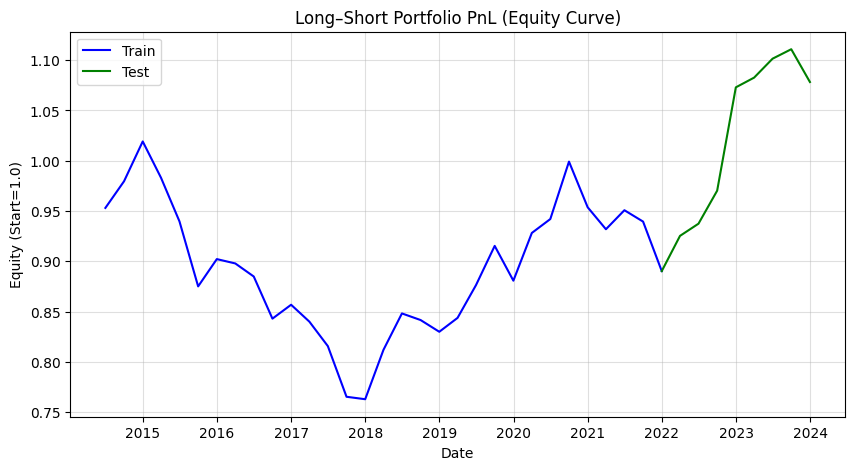

In [125]:
import matplotlib.pyplot as plt

# 누적 PnL
equity = (1 + port_df['ls_ret'].fillna(0)).cumprod()
equity.index = port_df['rebal_date']

train_end = pd.Timestamp("2021-12-31")
test_end  = pd.Timestamp("2023-12-31")

# 구간
train_curve = equity[equity.index <= train_end]
test_curve  = equity[(equity.index >= train_end) & (equity.index <= test_end)]

plt.figure(figsize=(10,5))

plt.plot(train_curve.index, train_curve.values, label="Train", color="blue")
plt.plot(test_curve.index,  test_curve.values,  label="Test", color="green")

plt.title("Long–Short Portfolio PnL (Equity Curve)")
plt.xlabel("Date")
plt.ylabel("Equity (Start=1.0)")
plt.legend()
plt.grid(True, alpha=0.4)
plt.show()

### **Backtesting Results**

### **1) Pnl Chart**

A PnL Chart (Profit and Loss Chart) is a visual representation of a trading or investment strategy’s cumulative profits and losses over time. It is a key output in backtesting and performance evaluation.

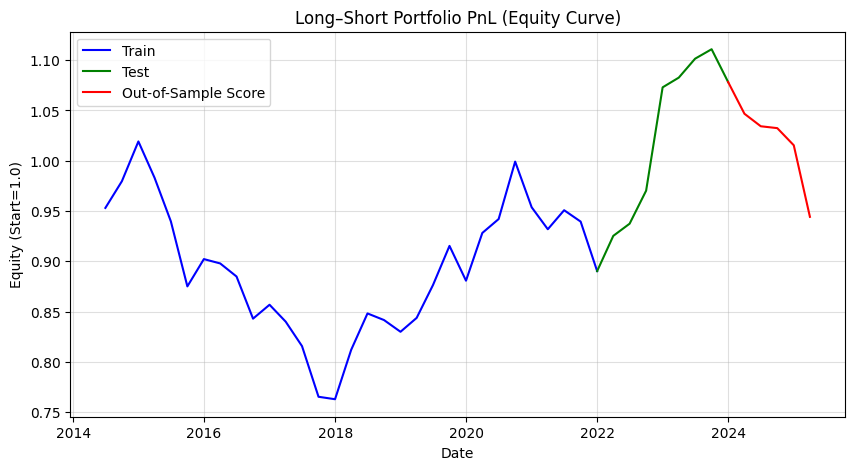

In [126]:
import matplotlib.pyplot as plt

# 누적 PnL
equity = (1 + port_df['ls_ret'].fillna(0)).cumprod()
equity.index = port_df['rebal_date']

train_end = pd.Timestamp("2021-12-31")
test_end  = pd.Timestamp("2023-12-31")

# 구간
train_curve = equity[equity.index <= train_end]
test_curve  = equity[(equity.index >= train_end) & (equity.index <= test_end)]
os_curve   = equity[equity.index >= test_end]

plt.figure(figsize=(10,5))

plt.plot(train_curve.index, train_curve.values, label="Train", color="blue")
plt.plot(test_curve.index,  test_curve.values,  label="Test", color="green")
plt.plot(os_curve.index,   os_curve.values,   label="Out-of-Sample Score", color="red")

plt.title("Long–Short Portfolio PnL (Equity Curve)")
plt.xlabel("Date")
plt.ylabel("Equity (Start=1.0)")
plt.legend()
plt.grid(True, alpha=0.4)
plt.show()

### **2) Sharpe Ratio**

The Sharpe Ratio is a standard measure used to evaluate the risk-adjusted return of an investment strategy or portfolio. It tells you how much excess return you are receiving for each unit of risk taken.

$$
\text{Sharpe Ratio} = \frac{R_p - R_f}{\sigma_p}
$$

In [127]:
# 기간 경계
train_end = pd.Timestamp("2021-12-31")
test_end  = pd.Timestamp("2023-12-31")

def label_period(d):
    if d <= train_end: return "Train"
    if d <= test_end:  return "Test"
    return "Out-of-Sample"

def sharpe_ratio(returns: pd.Series, freq=12):
    r = returns.dropna()
    if len(r) < 2:
        return np.nan
    mu = r.mean()
    vol = r.std(ddof=1)
    return (mu / vol) * np.sqrt(freq) if vol > 0 else np.nan

df_ret = port_df.copy()
df_ret["rebal_date"] = pd.to_datetime(df_ret["rebal_date"])
df_ret["period"] = df_ret["rebal_date"].apply(label_period)

# 기간별 롱숏 Sharpe만 계산
ls_sharpe = (
    df_ret.groupby("period")["ls_ret"]
          .apply(lambda s: sharpe_ratio(s, freq=12))
          .reindex(["Train","Test","Out-of-Sample"])
          .to_frame(name="Sharpe (LS)")
)

print(ls_sharpe)

               Sharpe (LS)
period                    
Train            -0.268595
Test              2.220874
Out-of-Sample    -3.375241


### **3) Turnover**

Turnover is a metric that indicates how frequently a portfolio is traded, specifically how often the portfolio's constituent assets are replaced.

$$
\text{Turnover}_t = \sum_{i=1}^{N} \left| w_{i,t}^{\text{new}} - w_{i,t}^{\text{old}} \right|
$$

In [128]:
from collections import defaultdict

dates = sorted(port_df["rebal_date"].dropna().unique().tolist())

def build_weight_map(legs: pd.DataFrame, sign: float):
    wmap = {}
    for d, g in legs.groupby("rebal_date"):
        names = g["Name"].tolist()
        if len(names) == 0:
            wmap[d] = {}
            continue
        w = sign * (1.0 / len(names))
        wmap[d] = {nm: w for nm in names}
    return wmap

w_long  = build_weight_map(long_legs,  sign=+1.0)
w_short = build_weight_map(short_legs, sign=-1.0)

# 턴오버 계산 함수
def series_turnover(dates, wmap):
    prev = defaultdict(float)
    rows = []
    for d in dates:
        curr = wmap.get(d, {})
        names = set(prev.keys()) | set(curr.keys())
        change = sum(abs(curr.get(n,0.0) - prev.get(n,0.0)) for n in names)
        to = 0.5 * change
        rows.append({"rebal_date": d, "turnover": to})
        prev = defaultdict(float, curr)
    return pd.DataFrame(rows)

to_long  = series_turnover(dates, w_long).rename(columns={"turnover":"turnover_long"})
to_short = series_turnover(dates, w_short).rename(columns={"turnover":"turnover_short"})

w_total = {}
for d in dates:
    wl = w_long.get(d, {})
    ws = w_short.get(d, {})
    comb = defaultdict(float, wl)
    for k,v in ws.items():
        comb[k] += v
    w_total[d] = dict(comb)

to_total = series_turnover(dates, w_total).rename(columns={"turnover":"turnover_ls"})

turnover_df = (port_df[["rebal_date"]]
               .merge(to_long,  on="rebal_date", how="left")
               .merge(to_short, on="rebal_date", how="left")
               .merge(to_total, on="rebal_date", how="left"))

print(turnover_df.head())

train_end = pd.Timestamp("2021-12-31")
test_end  = pd.Timestamp("2023-12-31")

def label_period(d):
    if d <= train_end: return "Train"
    if d <= test_end:  return "Test"
    return "Out-of-Sample"

turnover_df["period"] = turnover_df["rebal_date"].apply(label_period)

summary_turnover = (turnover_df
                    .groupby("period")[["turnover_long","turnover_short","turnover_ls"]]
                    .mean()
                    .sort_index())
print("\n평균 Turnover by Period")
print(summary_turnover)

  rebal_date  turnover_long  turnover_short  turnover_ls
0 2014-06-30       0.500000        0.500000     1.000000
1 2014-09-30       0.730769        0.615385     1.346154
2 2014-12-31       0.500000        0.615385     1.115385
3 2015-03-31       0.629630        0.740741     1.370370
4 2015-06-30       0.444444        0.777778     1.222222

평균 Turnover by Period
               turnover_long  turnover_short  turnover_ls
period                                                   
Out-of-Sample       0.596078        0.762389     1.358467
Test                0.600050        0.692288     1.292339
Train               0.572403        0.702963     1.275366


### **3) Dollar Turnover**

$$
\text{Dollar Turnover}_t 
= \frac{\text{Traded Amount during period } t}{\text{Gross Book Size}}
$$

In [129]:
from collections import defaultdict

def build_weight_map(legs: pd.DataFrame, sign: float):
    wmap = {}
    for d, g in legs.groupby("rebal_date"):
        names = g["Name"].tolist()
        if len(names) == 0:
            wmap[d] = {}
            continue
        w = sign * (1.0 / len(names))
        wmap[d] = {nm: w for nm in names}
    return wmap

w_long  = build_weight_map(long_legs,  sign=+1.0)
w_short = build_weight_map(short_legs, sign=-1.0)

def price_on_or_after(gpx: pd.DataFrame, target_dt: pd.Timestamp):
    if gpx.empty or pd.isna(target_dt):
        return (pd.NaT, np.nan)
    idx = gpx["Date"].searchsorted(target_dt)
    if idx >= len(gpx):
        return (pd.NaT, np.nan)
    row = gpx.iloc[int(idx)]
    return (pd.Timestamp(row["Date"]), float(row["AdjClose"]))

# 두 날짜 사이 단순 수익률 r = P_t / P_{t-1} - 1
def period_return(name: str, prev_dt: pd.Timestamp, curr_dt: pd.Timestamp, px: pd.DataFrame):
    gpx = px.loc[px["Name"].eq(name), ["Date","AdjClose"]].sort_values("Date")
    prev_dt, p0 = price_on_or_after(gpx, prev_dt)
    curr_dt, p1 = price_on_or_after(gpx, curr_dt)
    if np.isnan(p0) or np.isnan(p1):
        return np.nan
    return (p1 / p0) - 1.0

def compute_dollar_turnover(dates, w_long, w_short, px, gross_long=1.0, gross_short=1.0):
    prev_w_long  = defaultdict(float)
    prev_w_short = defaultdict(float)
    prev_date = None

    rows = []
    for d in dates:
        tgt_long  = w_long.get(d, {})
        tgt_short = w_short.get(d, {})

        if prev_date is None:
            pre_long_weights  = defaultdict(float)
            pre_short_weights = defaultdict(float)
        else:
            def drift_weights(prev_w: dict, names_target: set, side: str):
                names_all = set(prev_w.keys())
                if len(names_all)==0:
                    return defaultdict(float)
                r = {nm: period_return(nm, prev_date, d, px) for nm in names_all}
                val = {nm: prev_w[nm] * (1.0 + (0.0 if np.isnan(r[nm]) else r[nm])) for nm in names_all}
                abs_sum = sum(abs(v) for v in val.values())
                if abs_sum <= 0:
                    return defaultdict(float)
                scale = (gross_long if side=="long" else gross_short) / abs_sum
                return defaultdict(float, {nm: v * scale for nm, v in val.items()})

            pre_long_weights  = drift_weights(prev_w_long,  set(tgt_long.keys()),  side="long")
            pre_short_weights = drift_weights(prev_w_short, set(tgt_short.keys()), side="short")

        def normalize_to_gross(wmap: dict, gross: float):
            if not wmap:
                return defaultdict(float)
            s = sum(abs(x) for x in wmap.values())
            if s == 0:
                return defaultdict(float)
            f = gross / s
            return defaultdict(float, {k: v * f for k, v in wmap.items()})

        tgt_long_norm  = normalize_to_gross(tgt_long,  gross_long)
        tgt_short_norm = normalize_to_gross(tgt_short, gross_short)

        def abs_change_sum(pre_w: dict, tgt_w: dict):
            names = set(pre_w.keys()) | set(tgt_w.keys())
            return sum(abs(tgt_w.get(n,0.0) - pre_w.get(n,0.0)) for n in names)

        traded_long  = abs_change_sum(pre_long_weights,  tgt_long_norm)
        traded_short = abs_change_sum(pre_short_weights, tgt_short_norm)

        gross_book = gross_long + gross_short
        turnover_ls = (traded_long + traded_short) / gross_book

        rows.append({
            "rebal_date": d,
            "turnover_long_dollar":  traded_long  / gross_book,
            "turnover_short_dollar": traded_short / gross_book,
            "turnover_ls_dollar":    turnover_ls
        })

        prev_w_long  = tgt_long_norm
        prev_w_short = tgt_short_norm
        prev_date = d

    return pd.DataFrame(rows)

dates = sorted(port_df["rebal_date"].dropna().unique().tolist())
turnover_dollar = compute_dollar_turnover(dates, w_long, w_short, px, gross_long=1.0, gross_short=1.0)

turnover_df_dollar = (
    port_df[["rebal_date"]]
      .drop_duplicates()
      .merge(turnover_dollar, on="rebal_date", how="left")
)

train_end = pd.Timestamp("2021-12-31")
test_end  = pd.Timestamp("2023-12-31")
def label_period(d):
    if d <= train_end: return "Train"
    if d <= test_end:  return "Test"
    return "Out-of-Sample"

turnover_df_dollar["period"] = turnover_df_dollar["rebal_date"].apply(label_period)

summary_turnover_dollar = (
    turnover_df_dollar.groupby("period")[["turnover_long_dollar","turnover_short_dollar","turnover_ls_dollar"]]
    .mean()
    .sort_index()
)

print("\n[Dollar 기준 Turnover by Period]")
print(summary_turnover_dollar)


[Dollar 기준 Turnover by Period]
               turnover_long_dollar  turnover_short_dollar  turnover_ls_dollar
period                                                                        
Out-of-Sample              0.617961               0.770260            1.388221
Test                       0.626911               0.706896            1.333807
Train                      0.603669               0.714970            1.318640


In [130]:
train_end = pd.Timestamp("2021-12-31")
test_end  = pd.Timestamp("2023-12-31")

def label_period(d):
    if d <= train_end: return "Train"
    if d <= test_end:  return "Test"
    return "Out-of-Sample"

df_ret = port_df.copy()
df_ret["period"] = df_ret["rebal_date"].apply(label_period)

FREQ_PER_YEAR = 12

def summarize(x, col):
    n = x[col].notna().sum()
    if n == 0:
        return pd.Series({"N":0, "mean":np.nan, "cumret":np.nan, "ann":np.nan})
    r = x[col].dropna().values
    cum = (1 + r).prod() - 1
    ann = (1 + r).prod()**(FREQ_PER_YEAR/len(r)) - 1
    return pd.Series({"N":len(r), "mean":np.mean(r), "cumret":cum, "ann":ann})

summary_ls = df_ret.groupby("period").apply(lambda g: summarize(g, "ls_ret"))
summary_long = df_ret.groupby("period").apply(lambda g: summarize(g, "long_ret"))
summary_short = df_ret.groupby("period").apply(lambda g: summarize(g, "short_ret"))

print("=== Long-Short (LS) Returns by Period ===")
print(summary_ls)
print("\n=== Long Returns by Period ===")
print(summary_long)
print("\n=== Short Returns by Period ===")
print(summary_short)

=== Long-Short (LS) Returns by Period ===
                  N      mean    cumret       ann
period                                           
Out-of-Sample   5.0 -0.025912 -0.124348 -0.272898
Test            8.0  0.024869  0.211196  0.332974
Train          31.0 -0.003012 -0.109746 -0.044002

=== Long Returns by Period ===
                  N      mean    cumret       ann
period                                           
Out-of-Sample   5.0  0.060579  0.295582  0.861726
Test            8.0  0.029002  0.238811  0.378821
Train          31.0  0.022127  0.567780  0.190129

=== Short Returns by Period ===
                  N      mean    cumret       ann
period                                           
Out-of-Sample   5.0  0.086492  0.445487  1.421219
Test            8.0  0.004133  0.018451  0.027804
Train          31.0  0.025139  0.778893  0.249776


C:\Users\shinw\AppData\Local\Temp\ipykernel_18804\3780993624.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary_ls = df_ret.groupby("period").apply(lambda g: summarize(g, "ls_ret"))
C:\Users\shinw\AppData\Local\Temp\ipykernel_18804\3780993624.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary_long = df_ret.groupby("period").apply(lambda g: summarize(g, "long_ret"))
C:\Users\shinw\AppData

### **4) Max drawdown**

Max Drawdown (MDD) is a risk metric that measures the maximum observed loss from a peak to a trough in a portfolio’s value over a specific period.

$$
\text{Max Drawdown} = \max_{t \in [0, T]} \left( \frac{\text{Peak}_t - \text{Trough}_t}{\text{Peak}_t} \right)
$$

In [131]:
df = port_df.copy()
df["rebal_date"] = pd.to_datetime(df["rebal_date"])
df = df.sort_values("rebal_date").set_index("rebal_date")

train_end = pd.Timestamp("2021-12-31")
test_end  = pd.Timestamp("2023-12-31")

def label_period(d):
    if d <= train_end: return "Train"
    if d <= test_end:  return "Test"
    return "Out-of-Sample"

df["period"] = [label_period(d) for d in df.index]

# drawdown 함수 정의
def equity_curve(returns: pd.Series) -> pd.Series:
    r = returns.fillna(0).values
    eq = np.cumprod(1 + r)
    return pd.Series(eq, index=returns.index, name="equity")

def drawdown_series(equity: pd.Series) -> pd.Series:
    peak = equity.cummax()
    dd = equity / peak - 1.0
    dd.name = "drawdown"
    return dd

def mdd_with_dates(dd: pd.Series, ret: pd.Series):
    if dd.empty:
        return {"MDD": np.nan, "start": pd.NaT, "trough": pd.NaT, "recovery": pd.NaT}
    trough = dd.idxmin()
    mdd = float(dd.loc[trough])
    eq = equity_curve(ret)
    peak_vals = eq.cummax()
    start = peak_vals.loc[:trough].idxmax()
    peak_before = peak_vals.loc[start]
    after = eq.loc[trough:]
    rec = after[after >= peak_before]
    recovery = rec.index[0] if len(rec) else pd.NaT
    return {"MDD": mdd, "start": start, "trough": trough, "recovery": recovery}

periods = ["Train", "Test", "Out-of-Sample"]
per_period_results = {}
summary_rows = []

for p in periods:
    sub = df[df["period"] == p]["ls_ret"]
    if sub.empty:
        per_period_results[p] = {"equity": pd.Series(dtype=float), "dd": pd.Series(dtype=float)}
        summary_rows.append({"period": p, "MDD": np.nan, "start": pd.NaT, "trough": pd.NaT, "recovery": pd.NaT})
        continue

    eq = equity_curve(sub)
    dd = drawdown_series(eq)
    info = mdd_with_dates(dd, sub)

    per_period_results[p] = {"equity": eq, "dd": dd}
    summary_rows.append({"period": p, **info})

summary_dd = pd.DataFrame(summary_rows)[["period","MDD","start","trough","recovery"]]
print("=== Max Drawdown per Period ===")
print(summary_dd)

=== Max Drawdown per Period ===
          period       MDD      start     trough recovery
0          Train -0.251509 2014-12-31 2017-12-31      NaT
1           Test -0.029354 2023-09-30 2023-12-31      NaT
2  Out-of-Sample -0.097950 2024-03-31 2025-03-31      NaT


### **5) Annual Portfolio Performance**

In [132]:
from collections import defaultdict

def sharpe_ratio(returns: pd.Series, freq=12):
    r = returns.dropna()
    if len(r) < 2:
        return np.nan
    mu = r.mean()
    vol = r.std(ddof=1)
    return (mu / vol) * np.sqrt(freq) if vol > 0 else np.nan

def equity_curve(returns: pd.Series) -> pd.Series:
    r = returns.fillna(0).values
    eq = np.cumprod(1 + r)
    return pd.Series(eq, index=returns.index, name="equity")

def drawdown_series(equity: pd.Series) -> pd.Series:
    peak = equity.cummax()
    dd = equity / peak - 1.0
    dd.name = "drawdown"
    return dd

def max_drawdown(returns: pd.Series) -> float:
    if returns is None or returns.empty:
        return np.nan
    eq = equity_curve(returns)
    dd = drawdown_series(eq)
    return float(dd.min()) if len(dd) else np.nan

df_ret = port_df.copy()
df_ret["rebal_date"] = pd.to_datetime(df_ret["rebal_date"])
df_ret = df_ret.sort_values("rebal_date").reset_index(drop=True)
df_ret["year"] = df_ret["rebal_date"].dt.year
dates = df_ret["rebal_date"].tolist()

px = px.copy()
px["Date"] = pd.to_datetime(px["Date"])
px["AdjClose"] = pd.to_numeric(px["AdjClose"], errors="coerce")

def build_weight_map(legs: pd.DataFrame, sign: float):
    wmap = {}
    if legs is None or legs.empty:
        return wmap
    for d, g in legs.groupby("rebal_date"):
        names = g["Name"].tolist()
        if len(names) == 0:
            wmap[d] = {}
            continue
        w = sign * (1.0 / len(names))
        wmap[d] = {nm: w for nm in names}
    return wmap

w_long  = build_weight_map(long_legs,  +1.0)
w_short = build_weight_map(short_legs, -1.0)

def price_on_or_after(gpx: pd.DataFrame, target_dt: pd.Timestamp):
    if gpx.empty or pd.isna(target_dt):
        return (pd.NaT, np.nan)
    idx = gpx["Date"].searchsorted(target_dt)
    if idx >= len(gpx):
        return (pd.NaT, np.nan)
    row = gpx.iloc[int(idx)]
    return (pd.Timestamp(row["Date"]), float(row["AdjClose"]))

def period_return(name: str, prev_dt: pd.Timestamp, curr_dt: pd.Timestamp, px: pd.DataFrame):
    gpx = px.loc[px["Name"].eq(name), ["Date","AdjClose"]].sort_values("Date")
    prev_dt, p0 = price_on_or_after(gpx, prev_dt)
    curr_dt, p1 = price_on_or_after(gpx, curr_dt)
    if np.isnan(p0) or np.isnan(p1):
        return np.nan
    return (p1 / p0) - 1.0

def normalize_to_gross(wmap: dict, gross: float):
    if not wmap:
        return defaultdict(float)
    s = sum(abs(x) for x in wmap.values())
    if s == 0:
        return defaultdict(float)
    f = gross / s
    return defaultdict(float, {k: v * f for k, v in wmap.items()})

def compute_dollar_turnover(dates, w_long, w_short, px, gross_long=1.0, gross_short=1.0):
    prev_w_long  = defaultdict(float)
    prev_w_short = defaultdict(float)
    prev_date = None

    rows = []
    for d in dates:
        tgt_long  = w_long.get(d, {})
        tgt_short = w_short.get(d, {})

        if prev_date is None:
            pre_long_weights  = defaultdict(float)
            pre_short_weights = defaultdict(float)
        else:
            def drift_weights(prev_w: dict, side: str):
                names = set(prev_w.keys())
                if len(names) == 0:
                    return defaultdict(float)
                r = {nm: period_return(nm, prev_date, d, px) for nm in names}
                val = {nm: prev_w[nm] * (1.0 + (0.0 if np.isnan(r[nm]) else r[nm])) for nm in names}
                abs_sum = sum(abs(v) for v in val.values())
                if abs_sum <= 0:
                    return defaultdict(float)
                gross = gross_long if side == "long" else gross_short
                scale = gross / abs_sum
                return defaultdict(float, {nm: v * scale for nm, v in val.items()})

            pre_long_weights  = drift_weights(prev_w_long,  side="long")
            pre_short_weights = drift_weights(prev_w_short, side="short")

        tgt_long_norm  = normalize_to_gross(tgt_long,  gross_long)
        tgt_short_norm = normalize_to_gross(tgt_short, gross_short)

        def abs_change_sum(pre_w: dict, tgt_w: dict):
            names = set(pre_w.keys()) | set(tgt_w.keys())
            return sum(abs(tgt_w.get(n,0.0) - pre_w.get(n,0.0)) for n in names)

        traded_long  = abs_change_sum(pre_long_weights,  tgt_long_norm)
        traded_short = abs_change_sum(pre_short_weights, tgt_short_norm)

        gross_book = gross_long + gross_short
        turnover_ls_dollar = (traded_long + traded_short) / gross_book

        rows.append({
            "rebal_date": d,
            "turnover_long_dollar":  traded_long  / gross_book,
            "turnover_short_dollar": traded_short / gross_book,
            "turnover_ls_dollar":    turnover_ls_dollar
        })

        prev_w_long  = tgt_long_norm
        prev_w_short = tgt_short_norm
        prev_date = d

    return pd.DataFrame(rows)

turnover_dollar = compute_dollar_turnover(
    dates=dates,
    w_long=w_long,
    w_short=w_short,
    px=px,
    gross_long=1.0,
    gross_short=1.0
)

turnover_df = (
    df_ret[["rebal_date","year"]]
      .merge(turnover_dollar, on="rebal_date", how="left")
)

def summarize_year(group: pd.DataFrame):
    r = group["ls_ret"].dropna()
    year_dict = {
        "N": int(r.shape[0]),
        "Sharpe_LS": sharpe_ratio(r, freq=12),
        "Return_LS_cum": (1 + r).prod() - 1,
        "Return_LS_mean": r.mean(),
        "Vol_LS": r.std(ddof=1),
        "MDD_LS": max_drawdown(r),
        "Turnover_LS_mean": group["turnover_ls_dollar"].mean(skipna=True),
        "Turnover_LS_sum":  group["turnover_ls_dollar"].sum(skipna=True),
    }
    return pd.Series(year_dict)

annual = (
    df_ret.merge(turnover_df[["rebal_date","turnover_ls_dollar"]], on="rebal_date", how="left")
          .groupby("year", sort=True)
          .apply(summarize_year)
)

annual = annual[["Sharpe_LS","Return_LS_cum","Return_LS_mean","Vol_LS","MDD_LS","Turnover_LS_mean"]]

print("=== Yearly Metrics (Long–Short) with Dollar Turnover ===")
annual = annual.drop(index=2025, errors='ignore')
annual

=== Yearly Metrics (Long–Short) with Dollar Turnover ===


C:\Users\shinw\AppData\Local\Temp\ipykernel_18804\1484829380.py:168: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(summarize_year)


,Sharpe_LS,Return_LS_cum,Return_LS_mean,Vol_LS,MDD_LS,Turnover_LS_mean
year,,,,,,
2014,0.521058,0.019176,0.007102,0.047219,0.000000,1.198554
2015,-2.382974,-0.114793,-0.029334,0.042642,-0.109913,1.228806
2016,-1.638777,-0.050315,-0.012554,0.026538,-0.061138,1.304106
2017,-3.985047,-0.109647,-0.028380,0.024670,-0.091827,1.317922
2018,1.958201,0.087914,0.021835,0.038627,-0.021506,1.294071
2019,1.431882,0.061231,0.015497,0.037492,-0.037792,1.396035
2020,1.494662,0.082888,0.020993,0.048655,-0.045433,1.444457
2021,-1.929501,-0.066553,-0.016727,0.030030,-0.063671,1.335146
2022,4.179869,0.205247,0.048341,0.040063,0.000000,1.289589


**-> The strategy performs exceptionally well in certain market environments, but suffers from performance breakdowns in some years. Its very high turnover raises concerns about transaction costs and real-world implementability.**

## **Step 6. Market Neutralization**

**Concept**

Even a long–short portfolio can have a certain correlation with the **KOSPI200**.\
In this case, part of the portfolio return may simply reflect **market exposure (beta)**, rather than pure alpha.\
To address this, I adjust the portfolio returns by removing the component explained by the market, creating a **market-neutral** return series.

**Beta Estimation**

Beta is usually estimated using **OLS regression**

$$
r_{p,t} = \alpha + \beta \, r_{m,t} + \epsilon_t
$$

$$
\begin{aligned}
r_{p,t} & : \text{Portfolio return (long–short strategy)} \\
r_{m,t} & : \text{Market index return (KOSPI200)} \\
\beta   & : \text{Market sensitivity (how much the portfolio co-moves with the market)} \\
\epsilon_t & : \text{Residual after removing market exposure (pure alpha)}
\end{aligned}
$$

In practice, a simplified version without intercept is often used

$$
\beta = \frac{\text{Cov}(r_p, r_m)}{\text{Var}(r_m)}
$$

**Market-Neutral Return Formula**

After estimating beta, the **market-neutral return** is computed as

$$
r_{p,t}^{neutral} = r_{p,t} - \hat{\beta} \, r_{m,t}
$$

In [133]:
df_ret = port_df.copy()
df_ret["rebal_date"] = pd.to_datetime(df_ret["rebal_date"])
df_ret = df_ret.sort_values("rebal_date").reset_index(drop=True)
df_ret["year"] = df_ret["rebal_date"].dt.year
rebal_dates = df_ret["rebal_date"].tolist()

try:
    import FinanceDataReader as fdr
except ImportError:
    raise ImportError("FinanceDataReader가 없습니다. `pip install finance-datareader` 후 다시 실행하세요.")

MARKET_SYMBOL = "KS200"

start_date = (min(rebal_dates) - pd.Timedelta(days=10)).strftime("%Y-%m-%d")
end_date   = (max(rebal_dates) + pd.Timedelta(days=40)).strftime("%Y-%m-%d")

idx_df = fdr.DataReader(MARKET_SYMBOL, start_date, end_date)
idx_df = idx_df.rename_axis("Date").reset_index()[["Date","Close"]].dropna()
idx_df["Date"] = pd.to_datetime(idx_df["Date"])
idx_df = idx_df.sort_values("Date").reset_index(drop=True)
idx_df["mkt_ret_d"] = idx_df["Close"].pct_change()

def ret_between_dates(ret_df, date_col, ret_col, d0, d1):
    mask = (ret_df[date_col] >= d0) & (ret_df[date_col] < d1)
    r = ret_df.loc[mask, ret_col].dropna()
    return float((1 + r).prod() - 1) if len(r) else np.nan

mkt_rets = []
for i, d0 in enumerate(rebal_dates):
    d1 = rebal_dates[i+1] if i+1 < len(rebal_dates) else None
    if d1 is None:
        mkt_rets.append(np.nan)
    else:
        mkt_rets.append(ret_between_dates(idx_df, "Date", "mkt_ret_d", d0, d1))

df_ret["mkt_ret"] = mkt_rets

In [ ]:
# Beta estimation (static & rolling) + Beta-neutral returns

def beta_ols(y: pd.Series, x: pd.Series):
    """OLS slope without intercept (cov/var)."""
    y_ = y.astype(float); x_ = x.astype(float)
    mask = y_.notna() & x_.notna()
    if mask.sum() < 3:
        return np.nan
    xv = x_[mask].values
    yv = y_[mask].values
    var = np.var(xv, ddof=1)
    if var <= 0:
        return np.nan
    cov = np.cov(xv, yv, ddof=1)[0,1]
    return cov / var

# Static beta
beta_static = beta_ols(df_ret["ls_ret"], df_ret["mkt_ret"])
print(f"[Static Beta] beta_static = {beta_static:.4f}")

# Rolling beta
def rolling_beta_oos(y: pd.Series, x: pd.Series, window: int = 24) -> pd.Series:
    """
    Rolling beta using the previous 'window' observations only.
    At time t, beta is estimated from [t-window, t-1], excluding current period.
    """
    out = []
    for i in range(len(y)):
        lo = max(0, i - window); hi = i
        if hi - lo >= 3:
            out.append(beta_ols(y.iloc[lo:hi], x.iloc[lo:hi]))
        else:
            out.append(np.nan)
    return pd.Series(out, index=y.index, name=f"beta_oos_{window}")

df_ret["beta_24m"] = rolling_beta_oos(df_ret["ls_ret"], df_ret["mkt_ret"], window=24)

# Static beta-neutral
df_ret["ls_ret_neutral_static"] = df_ret["ls_ret"] - beta_static * df_ret["mkt_ret"]

# Rolling beta-neutral
df_ret["ls_ret_neutral_roll24"] = df_ret["ls_ret"] - df_ret["beta_24m"] * df_ret["mkt_ret"]

[Static Beta] beta_static = 0.1105


In [135]:
def sharpe_ratio(returns: pd.Series, freq=12):
    r = returns.dropna()
    if len(r) < 2: return np.nan
    mu = r.mean()
    vol = r.std(ddof=1)
    return (mu/vol)*np.sqrt(freq) if vol>0 else np.nan

def equity_curve(returns: pd.Series) -> pd.Series:
    r = returns.fillna(0).values
    eq = np.cumprod(1 + r)
    return pd.Series(eq, index=returns.index)

def max_drawdown(returns: pd.Series) -> float:
    if returns is None or returns.empty: return np.nan
    eq = equity_curve(returns)
    dd = eq/eq.cummax() - 1
    return float(dd.min()) if len(dd) else np.nan

def yr_summary(ret: pd.Series, years: pd.Series) -> pd.DataFrame:
    df = pd.DataFrame({"ret": ret, "year": years})
    def agg(g):
        r = g["ret"].dropna()
        return pd.Series({
            "N": int(r.shape[0]),
            "Sharpe": sharpe_ratio(r),
            "CumRet": (1+r).prod()-1,
            "Mean": r.mean(),
            "Vol": r.std(ddof=1),
            "MDD": max_drawdown(r),
        })
    return df.groupby("year").apply(agg)

print("\n=== 원본 LS ===")
print(yr_summary(df_ret["ls_ret"], df_ret["year"]).drop(index=2025, errors="ignore"))


=== 원본 LS ===
        N    Sharpe    CumRet      Mean       Vol       MDD
year                                                       
2014  3.0  0.521058  0.019176  0.007102  0.047219  0.000000
2015  4.0 -2.382974 -0.114793 -0.029334  0.042642 -0.109913
2016  4.0 -1.638777 -0.050315 -0.012554  0.026538 -0.061138
2017  4.0 -3.985047 -0.109647 -0.028380  0.024670 -0.091827
2018  4.0  1.958201  0.087914  0.021835  0.038627 -0.021506
2019  4.0  1.431882  0.061231  0.015497  0.037492 -0.037792
2020  4.0  1.494662  0.082888  0.020993  0.048655 -0.045433
2021  4.0 -1.929501 -0.066553 -0.016727  0.030030 -0.063671
2022  4.0  4.179869  0.205247  0.048341  0.040063  0.000000
2023  4.0  0.231610  0.004936  0.001397  0.020901 -0.029354
2024  4.0 -4.519816 -0.058348 -0.014868  0.011395 -0.029961


C:\Users\shinw\AppData\Local\Temp\ipykernel_18804\2083852751.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby("year").apply(agg)


In [136]:
print("\n=== 베타-중립(정적) LS ===")
print(yr_summary(df_ret["ls_ret_neutral_static"], df_ret["year"]).drop(index=2025, errors="ignore"))


=== 베타-중립(정적) LS ===
        N    Sharpe    CumRet      Mean       Vol       MDD
year                                                       
2014  3.0  0.547440  0.020084  0.007387  0.046743  0.000000
2015  4.0 -2.364942 -0.111183 -0.028377  0.041566 -0.105758
2016  4.0 -2.367886 -0.064854 -0.016403  0.023996 -0.068832
2017  4.0 -4.126211 -0.121592 -0.031618  0.026544 -0.093028
2018  4.0  2.188210  0.101689  0.025084  0.039710 -0.019980
2019  4.0  2.683508  0.079285  0.019493  0.025163 -0.014717
2020  4.0  0.291067  0.011102  0.003381  0.040236 -0.053191
2021  4.0 -1.442792 -0.053461 -0.013260  0.031838 -0.053885
2022  4.0  5.532357  0.220947  0.051540  0.032272  0.000000
2023  4.0 -0.502910 -0.014050 -0.003332  0.022948 -0.036464
2024  4.0 -2.294960 -0.050620 -0.012762  0.019263 -0.025263


C:\Users\shinw\AppData\Local\Temp\ipykernel_18804\2083852751.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby("year").apply(agg)


In [137]:
print("\n=== 베타-중립(롤링 24M) LS ===")
print(yr_summary(df_ret["ls_ret_neutral_roll24"], df_ret["year"]).drop(index=2025, errors="ignore"))


=== 베타-중립(롤링 24M) LS ===
        N    Sharpe    CumRet      Mean       Vol       MDD
year                                                       
2014  0.0       NaN  0.000000       NaN       NaN       NaN
2015  4.0 -2.204650 -0.110643 -0.028138  0.044212 -0.105916
2016  4.0 -2.613585 -0.072983 -0.018536  0.024568 -0.076358
2017  4.0 -4.344838 -0.131776 -0.034418  0.027441 -0.093865
2018  4.0  1.839709  0.088134  0.021966  0.041361 -0.025474
2019  4.0  1.522254  0.066425  0.016753  0.038124 -0.036776
2020  4.0  0.256284  0.010063  0.003234  0.043711 -0.057334
2021  4.0 -1.342307 -0.052463 -0.012962  0.033451 -0.053505
2022  4.0  5.432344  0.225514  0.052551  0.033511  0.000000
2023  4.0 -0.608124 -0.017328 -0.004149  0.023633 -0.039814
2024  4.0 -1.947901 -0.048309 -0.012126  0.021565 -0.027739


C:\Users\shinw\AppData\Local\Temp\ipykernel_18804\2083852751.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby("year").apply(agg)


In [138]:
port_df = df_ret.copy()

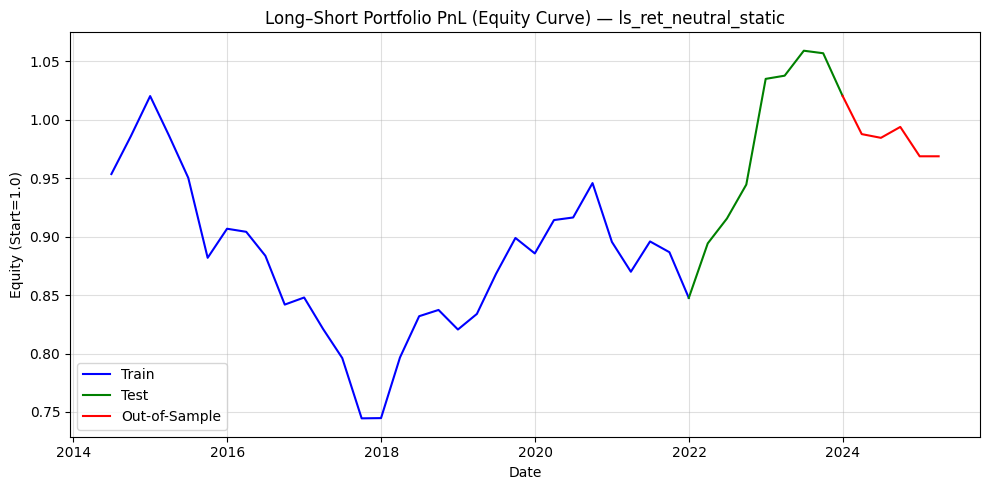

In [139]:
RET_COL = "ls_ret_neutral_static"

if RET_COL not in port_df.columns:
    raise KeyError(f"'{RET_COL}' 컬럼을 port_df에 만들어 주세요.")

dfp = port_df.copy()
dfp["rebal_date"] = pd.to_datetime(dfp["rebal_date"])
dfp = dfp.sort_values("rebal_date").reset_index(drop=True)

equity = (1 + dfp[RET_COL].fillna(0)).cumprod()
equity.index = dfp["rebal_date"]

train_end = pd.Timestamp("2021-12-31")
test_end  = pd.Timestamp("2023-12-31")

train_curve = equity[equity.index <= train_end]
test_curve  = equity[(equity.index >= train_end) & (equity.index <= test_end)]
os_curve    = equity[equity.index >= test_end]

plt.figure(figsize=(10, 5))

plt.plot(train_curve.index, train_curve.values, label="Train", color="blue")
plt.plot(test_curve.index,  test_curve.values,  label="Test",  color="green")
plt.plot(os_curve.index,    os_curve.values,    label="Out-of-Sample", color="red")

plt.title(f"Long–Short Portfolio PnL (Equity Curve) — {RET_COL}")
plt.xlabel("Date")
plt.ylabel("Equity (Start=1.0)")
plt.legend()
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()


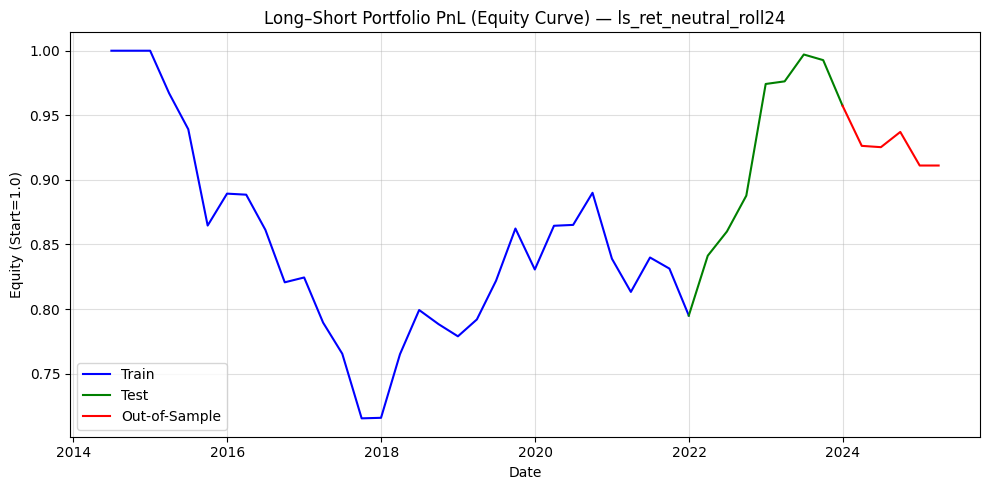

In [140]:
RET_COL = "ls_ret_neutral_roll24"

if RET_COL not in port_df.columns:
    raise KeyError(f"'{RET_COL}' 컬럼을 port_df에 만들어 주세요.")

dfp = port_df.copy()
dfp["rebal_date"] = pd.to_datetime(dfp["rebal_date"])
dfp = dfp.sort_values("rebal_date").reset_index(drop=True)

equity = (1 + dfp[RET_COL].fillna(0)).cumprod()
equity.index = dfp["rebal_date"]

train_end = pd.Timestamp("2021-12-31")
test_end  = pd.Timestamp("2023-12-31")

train_curve = equity[equity.index <= train_end]
test_curve  = equity[(equity.index >= train_end) & (equity.index <= test_end)]
os_curve    = equity[equity.index >= test_end]

plt.figure(figsize=(10, 5))

plt.plot(train_curve.index, train_curve.values, label="Train", color="blue")
plt.plot(test_curve.index,  test_curve.values,  label="Test",  color="green")
plt.plot(os_curve.index,    os_curve.values,    label="Out-of-Sample", color="red")

plt.title(f"Long–Short Portfolio PnL (Equity Curve) — {RET_COL}")
plt.xlabel("Date")
plt.ylabel("Equity (Start=1.0)")
plt.legend()
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()

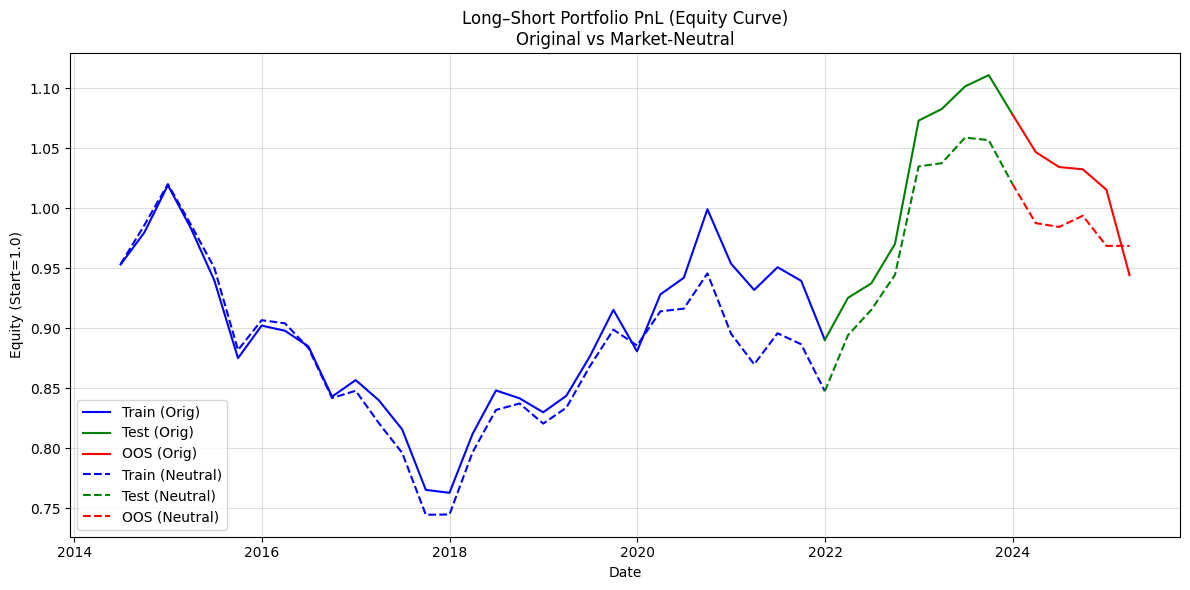

In [141]:
if "ls_ret_neutral_static" not in port_df.columns:
    port_df = port_df.merge(
        df_ret[["rebal_date","ls_ret_neutral_static","ls_ret_neutral_roll24"]],
        on="rebal_date",
        how="left"
    )

equity_orig   = (1 + port_df["ls_ret"].fillna(0)).cumprod()
equity_neutral = (1 + port_df["ls_ret_neutral_static"].fillna(0)).cumprod()

equity_orig.index   = port_df["rebal_date"]
equity_neutral.index = port_df["rebal_date"]

train_end = pd.Timestamp("2021-12-31")
test_end  = pd.Timestamp("2023-12-31")

def split_curve(equity):
    train = equity[equity.index <= train_end]
    test  = equity[(equity.index >= train_end) & (equity.index <= test_end)]
    oos   = equity[equity.index >= test_end]
    return train, test, oos

train_o, test_o, oos_o = split_curve(equity_orig)
train_n, test_n, oos_n = split_curve(equity_neutral)

plt.figure(figsize=(12,6))

# 원본 LS
plt.plot(train_o.index, train_o.values, label="Train (Orig)", color="blue", linestyle="-")
plt.plot(test_o.index,  test_o.values,  label="Test (Orig)", color="green", linestyle="-")
plt.plot(oos_o.index,   oos_o.values,   label="OOS (Orig)", color="red", linestyle="-")

# 베타-중립 LS
plt.plot(train_n.index, train_n.values, label="Train (Neutral)", color="blue", linestyle="--")
plt.plot(test_n.index,  test_n.values,  label="Test (Neutral)", color="green", linestyle="--")
plt.plot(oos_n.index,   oos_n.values,   label="OOS (Neutral)", color="red", linestyle="--")

plt.title("Long–Short Portfolio PnL (Equity Curve)\nOriginal vs Market-Neutral")
plt.xlabel("Date")
plt.ylabel("Equity (Start=1.0)")
plt.legend()
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()

### **Results**

The equity curves indicate that applying market neutralization did not improve the overall performance of the long-short strategy. While the training period shows only marginal differences between the original and market-neutral portfolios, the test and out-of-sample periods demonstrate weaker performance after neutralization.

In particular, during the OOS period, the market-neutral portfolio underperformed compared to the original strategy, suggesting that the benefits of market neutrality (e.g., hedging against market beta) did not outweigh the cost of reduced exposure to systematic factors.

### **Step 7. Decay**

=== Yearly Metrics (Long–Short; Decay=1M) ===


C:\Users\shinw\AppData\Local\Temp\ipykernel_18804\2343610183.py:136: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  annual = port_df.groupby("year", sort=True).apply(summarize_year)


,N,Sharpe_LS,Return_LS_cum,Return_LS_mean,Vol_LS,MDD_LS
year,,,,,,
2014,3.0,-0.995468,-0.103001,-0.031498,0.109608,-0.132566
2015,4.0,0.484376,0.019849,0.005498,0.039318,-0.002949
2016,4.0,1.843422,0.112358,0.028024,0.052662,-0.050212
2017,4.0,-1.094488,-0.078808,-0.018948,0.059971,-0.130421
2018,4.0,1.687352,0.084925,0.021304,0.043737,-0.040718
2019,4.0,-3.648585,-0.089141,-0.022892,0.021734,-0.066489
2020,4.0,36.258601,0.576587,0.120590,0.011521,0.000000
2021,4.0,-0.788113,-0.026106,-0.006299,0.027689,-0.054846
2022,4.0,1.378222,0.094767,0.024285,0.061040,-0.056510


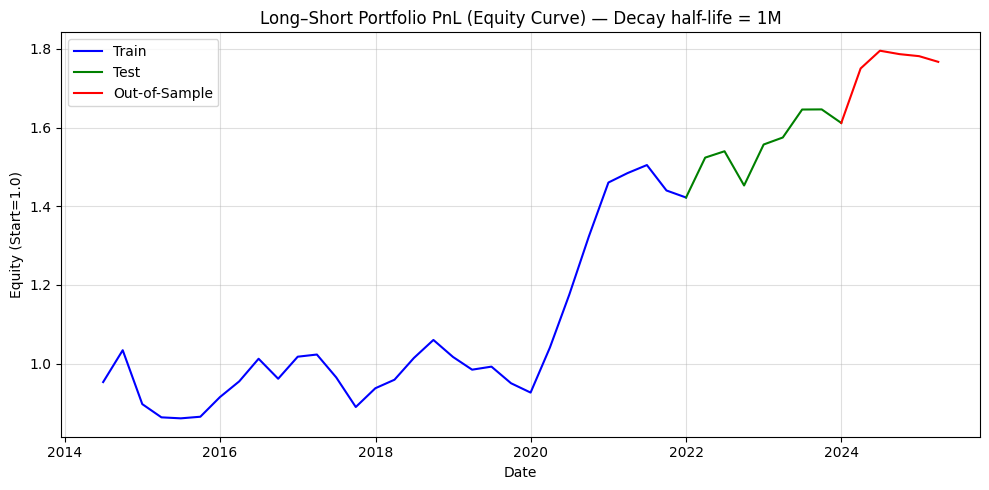

In [143]:
from pandas.tseries.offsets import MonthEnd

def sharpe_ratio(returns: pd.Series, freq=12):
    r = returns.dropna()
    if len(r) < 2: return np.nan
    mu = r.mean()
    vol = r.std(ddof=1)
    return (mu/vol)*np.sqrt(freq) if vol>0 else np.nan

def equity_curve(returns: pd.Series) -> pd.Series:
    r = returns.fillna(0).values
    eq = np.cumprod(1 + r)
    return pd.Series(eq, index=returns.index, name="equity")

def max_drawdown(returns: pd.Series) -> float:
    if returns is None or returns.empty:
        return np.nan
    eq = equity_curve(returns)
    dd = eq/eq.cummax() - 1.0
    return float(dd.min()) if len(dd) else np.nan

def apply_decay(signal_series: pd.Series, half_life: int = 1):
    lam = 0.5 ** (1 / half_life)
    return signal_series.ewm(alpha=1-lam, adjust=False).mean()

def first_trade_on_or_after(gpx: pd.DataFrame, target_dt: pd.Timestamp):
    if gpx.empty or pd.isna(target_dt):
        return (pd.NaT, np.nan)
    idx = gpx["Date"].searchsorted(target_dt)
    if idx >= len(gpx):
        return (pd.NaT, np.nan)
    row = gpx.iloc[int(idx)]
    return (pd.Timestamp(row["Date"]), float(row["AdjClose"]))

sig = merged_q_delayed.copy()
sig["trade_date"]  = pd.to_datetime(sig["trade_date"])
sig["signal_date"] = pd.to_datetime(sig["signal_date"])
sig["rebal_date"]  = sig["trade_date"] + MonthEnd(0)

sig["signal"] = pd.to_numeric(sig["Surprise_scaled"], errors="coerce")
sig = sig.replace([np.inf, -np.inf], np.nan)

sig = sig.sort_values(["Name","rebal_date","signal_date"])
signal_raw = (
    sig.dropna(subset=["signal"])
       .drop_duplicates(subset=["Name","rebal_date"], keep="last")[["rebal_date","Name","signal"]]
       .reset_index(drop=True)
)

signal_raw = signal_raw.sort_values(["Name","rebal_date"]).reset_index(drop=True)
signal_raw["signal"] = pd.to_numeric(signal_raw["signal"], errors="coerce").replace([np.inf,-np.inf], np.nan)

# decay
half_life = 4
lam = 0.5 ** (1/half_life)
alpha = 1 - lam

signal_raw["signal_decay"] = (
    signal_raw
      .sort_values(["Name","rebal_date"])
      .groupby("Name")["signal"]
      .transform(lambda s: s.ewm(alpha=alpha, adjust=False).mean())
)

Q = 0.20  # 상하위 20% 롱/숏
def pick_long_short(cross: pd.DataFrame):
    cross = cross.dropna(subset=["signal_decay"]).copy()
    if len(cross) < max(10, int(2/Q)):
        return pd.DataFrame(), pd.DataFrame()
    lo = cross["signal_decay"].quantile(Q)
    hi = cross["signal_decay"].quantile(1 - Q)
    long  = cross[cross["signal_decay"] <= lo].copy()
    short = cross[cross["signal_decay"] >= hi].copy()
    return long, short

px_use = px.copy()
px_use["Date"] = pd.to_datetime(px_use["Date"])
px_use["AdjClose"] = pd.to_numeric(px_use["AdjClose"], errors="coerce")
px_use = px_use.dropna(subset=["Name","Date","AdjClose"]).sort_values(["Name","Date"]).reset_index(drop=True)

rebal_dates = sorted(signal_raw["rebal_date"].unique().tolist())
rows_long, rows_short = [], []

for d in rebal_dates:
    cross = signal_raw[signal_raw["rebal_date"].eq(d)][["rebal_date","Name","signal_decay"]]
    long_legs, short_legs = pick_long_short(cross)

    exit_bucket = d + MonthEnd(1)
    for side, legs in [("long", long_legs), ("short", short_legs)]:
        if legs.empty: 
            continue
        for nm in legs["Name"]:
            gpx = px_use.loc[px_use["Name"].eq(nm), ["Date","AdjClose"]]
            in_dt,  in_px  = first_trade_on_or_after(gpx, d)
            out_dt, out_px = first_trade_on_or_after(gpx, exit_bucket)
            if not (np.isfinite(in_px) and np.isfinite(out_px)):
                continue
            ret = out_px / in_px - 1.0
            (rows_long if side=="long" else rows_short).append({
                "rebal_date": d, "Name": nm, "in_date": in_dt, "out_date": out_dt, "ret": ret
            })

long_df  = pd.DataFrame(rows_long)
short_df = pd.DataFrame(rows_short)

def avg_ret_per_date(df):
    if df.empty: 
        return pd.DataFrame(columns=["rebal_date","ret"])
    return (df.groupby("rebal_date")["ret"].mean().reset_index())

long_r  = avg_ret_per_date(long_df).rename(columns={"ret":"long_ret"})
short_r = avg_ret_per_date(short_df).rename(columns={"ret":"short_ret"})

port_df = (
    pd.DataFrame({"rebal_date": rebal_dates})
      .merge(long_r,  on="rebal_date", how="left")
      .merge(short_r, on="rebal_date", how="left")
      .sort_values("rebal_date").reset_index(drop=True)
)
port_df["ls_ret"] = port_df["long_ret"] - port_df["short_ret"]


port_df["year"] = pd.to_datetime(port_df["rebal_date"]).dt.year

def summarize_year(group: pd.DataFrame):
    r = group["ls_ret"].dropna()
    return pd.Series({
        "N": int(r.shape[0]),
        "Sharpe_LS": sharpe_ratio(r, freq=12),
        "Return_LS_cum": (1 + r).prod() - 1,
        "Return_LS_mean": r.mean(),
        "Vol_LS": r.std(ddof=1),
        "MDD_LS": max_drawdown(r),
    })

annual = port_df.groupby("year", sort=True).apply(summarize_year)
print("=== Yearly Metrics (Long–Short; Decay=1M) ===")
display(annual)

train_end = pd.Timestamp("2021-12-31")
test_end  = pd.Timestamp("2023-12-31")

equity = (1 + port_df["ls_ret"].fillna(0)).cumprod()
equity.index = pd.to_datetime(port_df["rebal_date"])

train_curve = equity[equity.index <= train_end]
test_curve  = equity[(equity.index >= train_end) & (equity.index <= test_end)]
oos_curve   = equity[equity.index >= test_end]

plt.figure(figsize=(10,5))
plt.plot(train_curve.index, train_curve.values, label="Train", color="blue")
plt.plot(test_curve.index,  test_curve.values,  label="Test",  color="green")
plt.plot(oos_curve.index,   oos_curve.values,   label="Out-of-Sample", color="red")
plt.title("Long–Short Portfolio PnL (Equity Curve) — Decay half-life = 1M")
plt.xlabel("Date"); plt.ylabel("Equity (Start=1.0)")
plt.legend(); plt.grid(True, alpha=0.4)
plt.tight_layout(); plt.show()

### **Step 8. Winsorize**

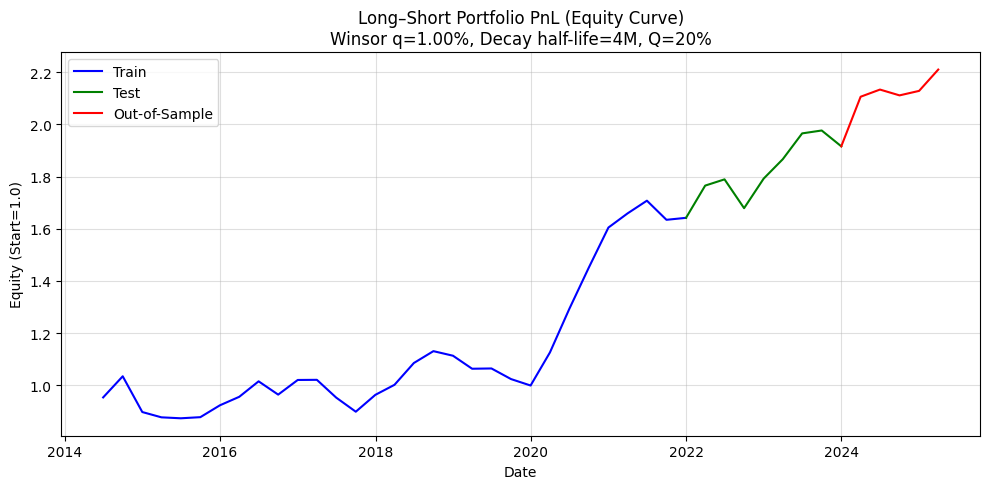

In [144]:
from pandas.tseries.offsets import MonthEnd

Q_LONGSHORT   = 0.20
WINSOR_Q      = 0.01     # winsorize
HALF_LIFE_M   = 4        # decay
HOLD_MONTHS   = 1
TRAIN_END     = pd.Timestamp("2021-12-31")
TEST_END      = pd.Timestamp("2023-12-31")


def first_trade_on_or_after(gpx: pd.DataFrame, target_dt: pd.Timestamp):
    if gpx.empty or pd.isna(target_dt):
        return (pd.NaT, np.nan)
    idx = gpx["Date"].searchsorted(target_dt)
    if idx >= len(gpx):
        return (pd.NaT, np.nan)
    row = gpx.iloc[int(idx)]
    return (pd.Timestamp(row["Date"]), float(row["AdjClose"]))

def apply_decay_series(s: pd.Series, half_life: float):
    lam = 0.5 ** (1/half_life)
    alpha = 1 - lam
    return s.ewm(alpha=alpha, adjust=False).mean()

def winsorize_series(x: pd.Series, q: float):
    lo, hi = x.quantile(q), x.quantile(1-q)
    return x.clip(lower=lo, upper=hi)

sig = merged_q_delayed.copy()
sig["trade_date"]  = pd.to_datetime(sig["trade_date"])
sig["signal_date"] = pd.to_datetime(sig["signal_date"])
sig["rebal_date"]  = sig["trade_date"] + MonthEnd(0)

sig["signal_raw"]  = pd.to_numeric(sig["Surprise_scaled"], errors="coerce")
sig.replace([np.inf, -np.inf], np.nan, inplace=True)

sig = sig.sort_values(["Name","rebal_date","signal_date"])
signal_raw = (
    sig.dropna(subset=["signal_raw"])
       .drop_duplicates(subset=["Name","rebal_date"], keep="last")
       [["rebal_date","Name","signal_raw"]]
       .reset_index(drop=True)
)

signal_raw["signal_winsor"] = (
    signal_raw.groupby("rebal_date")["signal_raw"]
              .transform(lambda x: winsorize_series(x, q=WINSOR_Q))
)

signal_raw = signal_raw.sort_values(["Name","rebal_date"]).reset_index(drop=True)
signal_raw["signal_decay"] = (
    signal_raw.groupby("Name")["signal_winsor"]
              .transform(lambda s: apply_decay_series(s, HALF_LIFE_M))
)

def pick_long_short(cross: pd.DataFrame, q=Q_LONGSHORT):
    cross = cross.dropna(subset=["signal_decay"]).copy()
    if cross.empty:
        return pd.DataFrame(), pd.DataFrame()
    lo = cross["signal_decay"].quantile(q)
    hi = cross["signal_decay"].quantile(1-q)
    return cross[cross["signal_decay"] <= lo], cross[cross["signal_decay"] >= hi]

px_use = px.copy()
px_use["Date"] = pd.to_datetime(px_use["Date"])
px_use["AdjClose"] = pd.to_numeric(px_use["AdjClose"], errors="coerce")
px_use = px_use.dropna(subset=["Name","Date","AdjClose"]).sort_values(["Name","Date"]).reset_index(drop=True)

rebal_dates = sorted(signal_raw["rebal_date"].unique().tolist())
rows_long, rows_short = [], []

for d in rebal_dates:
    cross = signal_raw.loc[signal_raw["rebal_date"].eq(d), ["rebal_date","Name","signal_decay"]]
    long_legs, short_legs = pick_long_short(cross, q=Q_LONGSHORT)
    if long_legs.empty and short_legs.empty:
        continue

    exit_bucket = d + MonthEnd(HOLD_MONTHS)
    for side, legs in [("long", long_legs), ("short", short_legs)]:
        for nm in legs["Name"]:
            gpx = px_use.loc[px_use["Name"].eq(nm), ["Date","AdjClose"]]
            in_dt,  in_px  = first_trade_on_or_after(gpx, d)
            out_dt, out_px = first_trade_on_or_after(gpx, exit_bucket)
            if not (np.isfinite(in_px) and np.isfinite(out_px)):
                continue
            ret = out_px / in_px - 1.0
            (rows_long if side=="long" else rows_short).append(
                {"rebal_date": d, "Name": nm, "ret": ret}
            )

def avg_ret(df):
    return df.groupby("rebal_date")["ret"].mean().reset_index() if not df.empty else pd.DataFrame(columns=["rebal_date","ret"])

long_r  = avg_ret(pd.DataFrame(rows_long)).rename(columns={"ret":"long_ret"})
short_r = avg_ret(pd.DataFrame(rows_short)).rename(columns={"ret":"short_ret"})

port_df = (
    pd.DataFrame({"rebal_date": rebal_dates})
      .merge(long_r,  on="rebal_date", how="left")
      .merge(short_r, on="rebal_date", how="left")
      .sort_values("rebal_date").reset_index(drop=True)
)
port_df["ls_ret"] = port_df["long_ret"] - port_df["short_ret"]


equity = (1 + port_df["ls_ret"].fillna(0)).cumprod()
equity.index = pd.to_datetime(port_df["rebal_date"])

train_curve = equity[equity.index <= TRAIN_END]
test_curve  = equity[(equity.index >= TRAIN_END) & (equity.index <= TEST_END)]
oos_curve   = equity[equity.index >= TEST_END]

plt.figure(figsize=(10,5))
plt.plot(train_curve.index, train_curve.values, label="Train", color="blue")
plt.plot(test_curve.index,  test_curve.values,  label="Test",  color="green")
plt.plot(oos_curve.index,   oos_curve.values,   label="Out-of-Sample", color="red")
plt.title(f"Long–Short Portfolio PnL (Equity Curve)\nWinsor q={WINSOR_Q:.2%}, Decay half-life={HALF_LIFE_M}M, Q={int(Q_LONGSHORT*100)}%")
plt.xlabel("Date"); plt.ylabel("Equity (Start=1.0)")
plt.legend(); plt.grid(True, alpha=0.4)
plt.tight_layout(); plt.show()

In [145]:
def sharpe_ratio(returns: pd.Series, freq=12):
    r = returns.dropna()
    if len(r) < 2: 
        return np.nan
    mu = r.mean()
    vol = r.std(ddof=1)
    return (mu / vol) * np.sqrt(freq) if vol > 0 else np.nan

def equity_curve(returns: pd.Series) -> pd.Series:
    r = returns.fillna(0).values
    eq = np.cumprod(1 + r)
    return pd.Series(eq, index=returns.index)

def max_drawdown(returns: pd.Series) -> float:
    if returns is None or returns.empty:
        return np.nan
    eq = equity_curve(returns)
    dd = eq / eq.cummax() - 1
    return float(dd.min()) if len(dd) else np.nan

def label_period(d):
    if d <= TRAIN_END: return "Train"
    if d <= TEST_END:  return "Test"
    return "Out-of-Sample"

port_df["period"] = pd.to_datetime(port_df["rebal_date"]).apply(label_period)

summary = []
for p, g in port_df.groupby("period"):
    r = g["ls_ret"].dropna()
    eq = equity_curve(r)
    row = {
        "Period": p,
        "N_months": len(r),
        "Sharpe": sharpe_ratio(r),
        "CumReturn": (1 + r).prod() - 1,
        "Mean": r.mean(),
        "Vol": r.std(ddof=1),
        "MDD": max_drawdown(r)
    }
    summary.append(row)

summary_df = pd.DataFrame(summary).set_index("Period")
print(summary_df.round(4))

               N_months  Sharpe  CumReturn    Mean     Vol     MDD
Period                                                            
Out-of-Sample         5  2.4127     0.1536  0.0297  0.0426 -0.0105
Test                  8  1.4696     0.1670  0.0205  0.0484 -0.0618
Train                31  0.9662     0.6418  0.0181  0.0650 -0.1557


In [146]:
long_df  = pd.DataFrame(rows_long)
short_df = pd.DataFrame(rows_short)

def label_period(d):
    if d <= TRAIN_END: return "Train"
    if d <= TEST_END:  return "Test"
    return "Out-of-Sample"

for df in [long_df, short_df]:
    df["period"] = pd.to_datetime(df["rebal_date"]).apply(label_period)

long_counts = (long_df.groupby(["period","rebal_date"])["Name"].count()
                      .groupby("period").mean().rename("avg_long_count"))
short_counts = (short_df.groupby(["period","rebal_date"])["Name"].count()
                       .groupby("period").mean().rename("avg_short_count"))

counts_summary = pd.concat([long_counts, short_counts], axis=1)
print("=== 평균 롱/숏 카운트 (구간별) ===")
print(counts_summary.round(2))

=== 평균 롱/숏 카운트 (구간별) ===
               avg_long_count  avg_short_count
period                                        
Out-of-Sample           33.20            33.20
Test                    31.25            31.25
Train                   28.71            28.71


In [147]:
port_df["year"] = pd.to_datetime(port_df["rebal_date"]).dt.year

def summarize_year(group: pd.DataFrame):
    r = group["ls_ret"].dropna()
    return pd.Series({
        "N_months": int(r.shape[0]),
        "Sharpe": sharpe_ratio(r, freq=12),
        "CumReturn": (1 + r).prod() - 1,
        "Mean": r.mean(),
        "Vol": r.std(ddof=1),
        "MDD": max_drawdown(r)
    })

annual_perf = port_df.groupby("year").apply(summarize_year)

print("=== 연도별 성과 요약 ===")
print(annual_perf.round(4))

=== 연도별 성과 요약 ===
      N_months   Sharpe  CumReturn    Mean     Vol     MDD
year                                                      
2014       3.0  -0.9955    -0.1030 -0.0315  0.1096 -0.1326
2015       4.0   0.8174     0.0288  0.0075  0.0317 -0.0042
2016       4.0   1.7434     0.1053  0.0264  0.0524 -0.0502
2017       4.0  -0.6929    -0.0559 -0.0128  0.0638 -0.1198
2018       4.0   3.1962     0.1558  0.0375  0.0406 -0.0155
2019       4.0  -4.5339    -0.1027 -0.0266  0.0203 -0.0615
2020       4.0  24.9264     0.6066  0.1259  0.0175  0.0000
2021       4.0   0.6127     0.0232  0.0062  0.0352 -0.0430
2022       4.0   1.2960     0.0916  0.0237  0.0632 -0.0618
2023       4.0   1.5898     0.0691  0.0174  0.0379 -0.0307
2024       4.0   1.9489     0.1109  0.0275  0.0489 -0.0105
2025       1.0      NaN     0.0384  0.0384     NaN  0.0000


C:\Users\shinw\AppData\Local\Temp\ipykernel_18804\4106482089.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  annual_perf = port_df.groupby("year").apply(summarize_year)


| Period    | N\_months | Sharpe | Mean Return | Volatility | MDD    |
| --------- | --------- | ------ | ----------- | ---------- | ------ |
| **Train** | 31        | 0.97   | **1.81%**   | 6.50%      | -15.6% |
| **Test**  | 8         | 1.47   | **2.05%**   | 4.84%      | -6.2%  |
| **OOS**   | 5         | 2.41   | **2.97%**   | 4.26%      | -1.1%  |